# Posterior Analysis Notebook
Select an experiment run, fit a posterior to the mixture data, and visualize the fit with 2D marginal plots.

In [1]:
# Experiment Run Selector
import glob
import os

import ipywidgets as widgets
from IPython.display import display

base_dir = "./data/"
run_folders = sorted(glob.glob(os.path.join(base_dir, "run_*/")))
run_options = [os.path.basename(f[:-1]) for f in run_folders]  # Remove trailing slash
run_selector = widgets.Dropdown(
    options=run_options,
    value=run_options[-1] if run_options else None,
    description="Experiment Run:",
    style={"description_width": "initial"},
)
display(run_selector)

Dropdown(description='Experiment Run:', options=('run_20260207_185326',), style=DescriptionStyle(description_w…

Dropdown(description='Experiment Run:', options=('run_20260207_185326',), style=DescriptionStyle(description_w…

In [2]:
# Fit posterior for multiple sample sizes and visualize with color-coding
import json

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from matplotlib import cm

selected_run = run_selector.value
run_path = os.path.join(base_dir, selected_run)
dgp_path = os.path.join(run_path, "dgp.json")

with open(dgp_path) as f:
    DGP = json.load(f)
means = DGP["means"]
stds = DGP["stds"]
weights = DGP["weights"]
sample_sizes = DGP["sample_sizes"]

# Fit posteriors for multiple sample sizes
traces = {}
all_samples_dict = {}
colors = cm.viridis(np.linspace(0, 1, len(sample_sizes)))

for idx, n in enumerate(sample_sizes):
    csv_path = os.path.join(run_path, f"mixture_samples_n{n}.csv")
    data = np.loadtxt(csv_path, delimiter=",")

    with pm.Model() as model:
        w = pm.Dirichlet("w", a=np.ones(2))
        mu = pm.Normal("mu", mu=0, sigma=5, shape=2)
        sigma = pm.HalfNormal("sigma", sigma=2, shape=2)
        comp = pm.Normal.dist(mu=mu, sigma=sigma, shape=2)
        mix = pm.Mixture("mix", w=w, comp_dists=comp, observed=data)
        trace = pm.sample(
            2000,
            tune=2000,
            chains=2,
            cores=2,
            return_inferencedata=True,
            random_seed=2026,
            progressbar=False,
            target_accept=0.99,
            verbose=False,
        )

    traces[n] = trace
    mu_samples = trace.posterior["mu"].values.reshape(-1, 2)
    sigma_samples = trace.posterior["sigma"].values.reshape(-1, 2)
    all_samples = np.concatenate([mu_samples, sigma_samples], axis=1)
    all_samples_dict[n] = (all_samples, colors[idx])

    print(f"Sampling for n={n} completed.\n")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [w, mu, sigma]


ValueError: Not enough samples to build a trace.

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [w, mu, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


Initializing NUTS using jitter+adapt_diag...


Sampling for n=50 completed.



Multiprocess sampling (2 chains in 2 jobs)


NUTS: [w, mu, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Initializing NUTS using jitter+adapt_diag...


Sampling for n=200 completed.



Multiprocess sampling (2 chains in 2 jobs)


NUTS: [w, mu, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling for n=5000 completed.



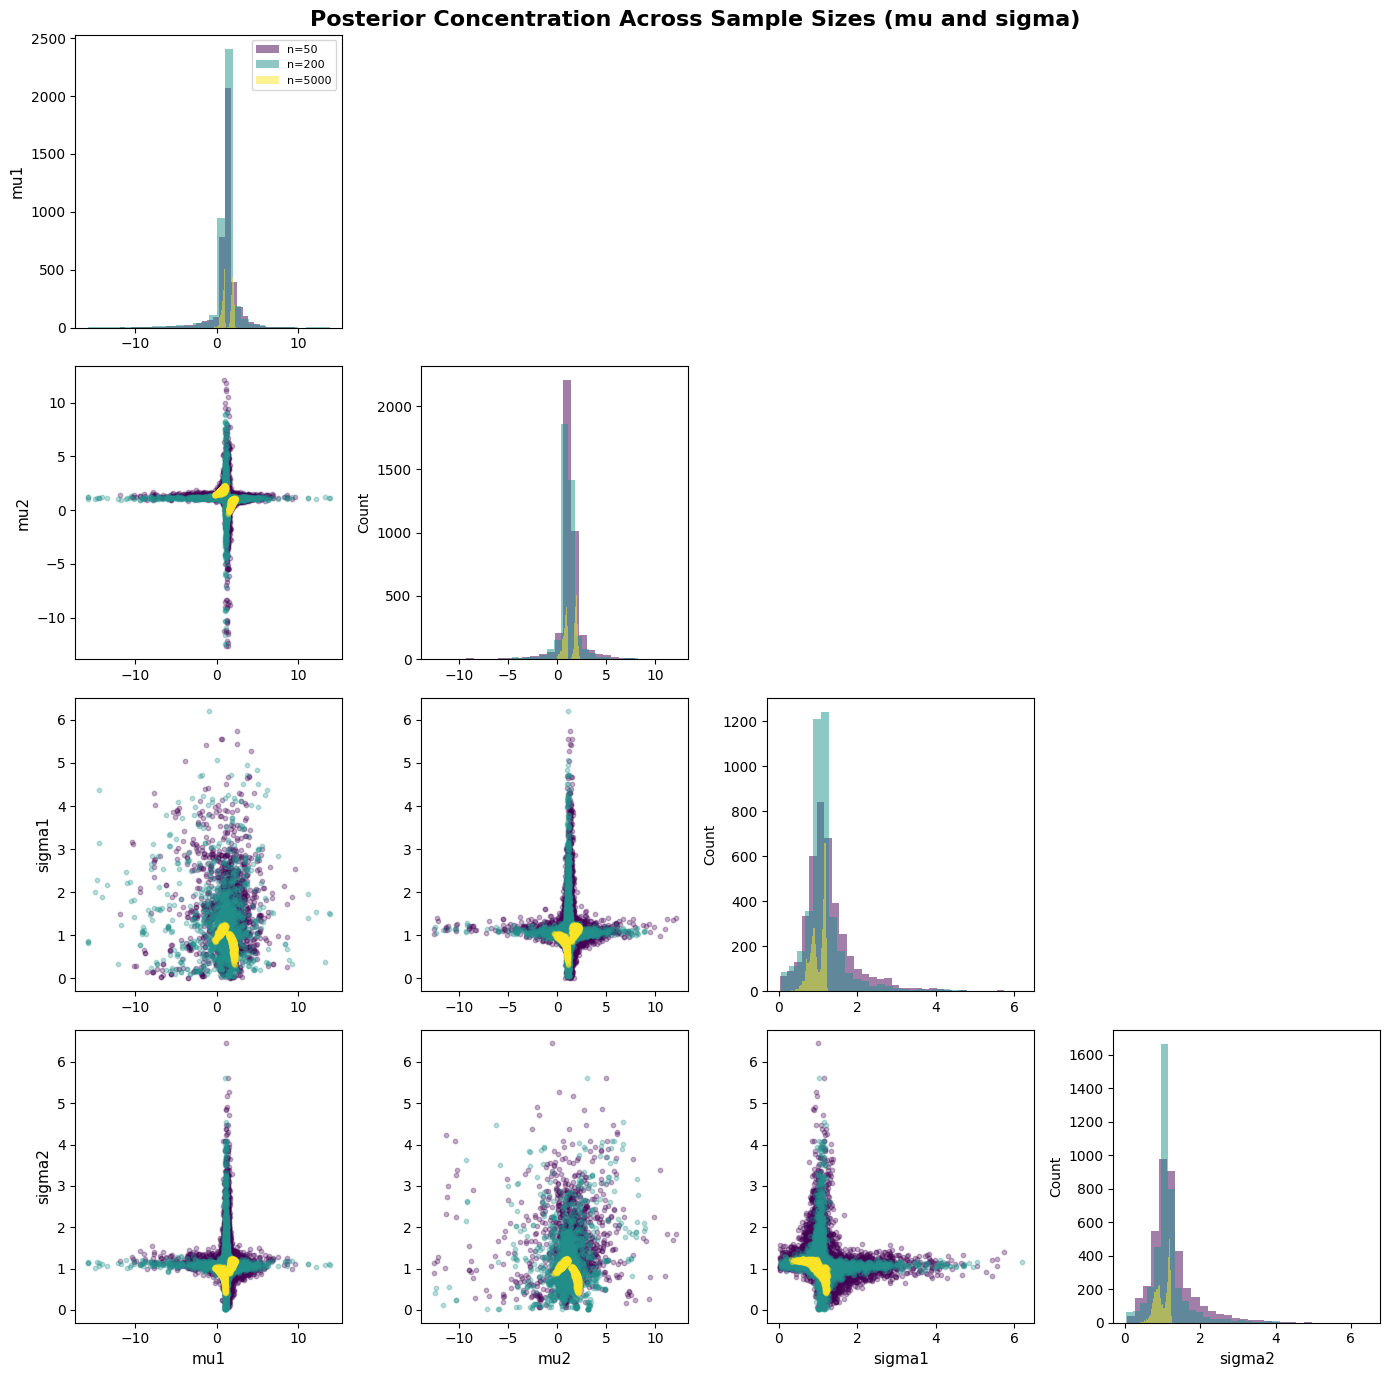

In [3]:
# Create grid plot with color-coded sample sizes
param_labels = ["mu1", "mu2", "sigma1", "sigma2"]
num_params = 4
fig, axes = plt.subplots(num_params, num_params, figsize=(14, 14))

for i in range(num_params):
    for j in range(num_params):
        ax = axes[i, j]
        if i == j:
            # Histograms with different colors for each sample size
            for n, (samples, color) in all_samples_dict.items():
                ax.hist(samples[:, i], bins=30, alpha=0.5, label=f"n={n}", color=color)
            ax.set_ylabel("Count")
            if i == 0:
                ax.legend(fontsize=8, loc="upper right")
        elif i > j:
            # Scatter plots with color-coding by sample size
            for n, (samples, color) in all_samples_dict.items():
                ax.scatter(
                    samples[:, j],
                    samples[:, i],
                    alpha=0.3,
                    s=10,
                    color=color,
                    label=f"n={n}",
                )
        else:
            ax.axis("off")

        if j == 0:
            ax.set_ylabel(param_labels[i], fontsize=11)
        if i == num_params - 1:
            ax.set_xlabel(param_labels[j], fontsize=11)

plt.suptitle(
    "Posterior Concentration Across Sample Sizes (mu and sigma)",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout()
plt.show()